In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.13.0


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
df = pd.read_csv('/content/drive/MyDrive/Mini ProjectRisk Msc DS/Main Project/NER/Dataset/NER dataset.csv', encoding='utf-8')
df = df.fillna(method='ffill')
df.head(-5)

,Word,POS,Sentence Id,Tag
0,Chinese,JJ,1,O
1,tech,NN,1,O
2,giant,NN,1,O
3,Alibaba,NNP,1,B-IDENTITY
4,has,VBZ,1,O
...,...,...,...,...
204805,wipers,NNS,6311,O
204806,that,WDT,6311,O
204807,have,VBP,6311,O
204808,been,VBN,6311,O


In [41]:
df['Sentence Id'].nunique(), df.Word.nunique(), df.Tag.nunique()

(6311, 16201, 25)

In [42]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['ner_tags'] = le.fit_transform(df['Tag'])
df['ner_tags'] = df['ner_tags'] + 1

In [43]:
df.groupby('ner_tags').size().reset_index(name='counts')

,ner_tags,counts
0,1,127
1,2,715
2,3,108
3,4,968
4,5,3972
5,6,345
6,7,348
7,8,1431
8,9,1111
9,10,470


In [44]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["ner_tags"].values.tolist())]
        self.grouped = self.data.groupby("Sentence Id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [45]:
getter = SentenceGetter(df)

In [46]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Chinese',
 'tech',
 'giant',
 'Alibaba',
 'has',
 'reportedly',
 'been',
 'shunned',
 'by',
 'Chinas',
 'top',
 'tech',
 'regulator',
 'for',
 'failing',
 'to',
 'report',
 'the',
 'infamous',
 'Log4j',
 'vulnerability',
 'quickly',
 'enough',
 '.']

In [47]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

[25, 25, 25, 5, 25, 25, 25, 25, 25, 8, 25, 25, 25, 25, 25, 25, 25, 25, 25, 11, 25, 25, 25, 25]


In [48]:
def split_tokens_and_labels(tokens_list, labels_list, max_length=75):
    new_tokens_list = []
    new_labels_list = []

    for tokens, labels in zip(tokens_list, labels_list):
        if len(tokens) <= max_length:
            new_tokens_list.append(tokens)
            new_labels_list.append(labels)
        else:
            start = 0
            end = max_length
            while start < len(tokens):
                new_tokens_list.append(tokens[start:end])
                new_labels_list.append(labels[start:end])
                start = end
                end = start + max_length

    return new_tokens_list, new_labels_list



In [49]:
new_tokens_list, new_labels_list = split_tokens_and_labels(sentences, labels, max_length=75)

Preprocess the sentence and labels. prepare to use with pytorch and bert

In [52]:
pip install transformers

In [53]:
pip install pytorch-crf

In [54]:
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import  TokenClassifierOutput
from torch import nn
from torch.nn import CrossEntropyLoss
import torch
from torchcrf import CRF

In [69]:
class BertLstmCRF(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config, dropout_prob=0.3, lstm_hidden_size=64):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(dropout_prob)

        lstm_hidden_size = lstm_hidden_size or (config.hidden_size) // 2
        self.bilstm = nn.LSTM(config.hidden_size, lstm_hidden_size, dropout=dropout_prob, batch_first=True, bidirectional=True)

        self.classifier = nn.Linear(lstm_hidden_size * 2, config.num_labels)
        self.crf = CRF(num_tags=config.num_labels, batch_first=True)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        lstm_output, hc = self.bilstm(sequence_output)
        logits = self.classifier(lstm_output)

        loss = None
        if labels is not None:
            log_likelihood, tags = self.crf(logits, labels), self.crf.decode(logits)
            loss = 0 - log_likelihood
        else:
            tags = self.crf.decode(logits)
        tags = torch.Tensor(tags)

        if not return_dict:
            output = (tags,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return loss, tags


In [56]:
!pip install datasets
!pip install transformers[torch]
!pip install accelerate>=0.20.1

In [57]:
from datasets import Dataset
data = {
    'tokens': new_tokens_list,
    'ner_tags': new_labels_list
}
dataset = Dataset.from_dict(data)

In [58]:
from sklearn.metrics import classification_report, f1_score
from transformers import BertTokenizerFast, Trainer, TrainingArguments,BertTokenizer
from transformers.trainer_utils import IntervalStrategy
from sklearn.model_selection import train_test_split


train_dataset, test_dataset = train_test_split(dataset, test_size = 0.2, random_state = 2018)
train_dataset = Dataset.from_dict(train_dataset)
test_dataset = Dataset.from_dict(test_dataset)

train_dataset = train_dataset.rename_column('ner_tags', 'label_ids')
test_dataset = test_dataset.rename_column('ner_tags', 'label_ids')

In [70]:
model = BertLstmCRF.from_pretrained('bert-base-cased', num_labels=26)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Some weights of BertLstmCRF were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bilstm.weight_ih_l0_reverse', 'classifier.weight', 'bilstm.bias_hh_l0_reverse', 'bilstm.bias_hh_l0', 'classifier.bias', 'bilstm.weight_hh_l0', 'crf.start_transitions', 'bilstm.bias_ih_l0_reverse', 'crf.transitions', 'bilstm.weight_ih_l0', 'bilstm.weight_hh_l0_reverse', 'bilstm.bias_ih_l0', 'crf.end_transitions']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    result = {
        'label_ids': [],
        'input_ids': [],
        'token_type_ids': [],
    }
    max_length = tokenizer.max_model_input_sizes['bert-base-cased']

    for tokens, label in zip(batch['tokens'], batch['label_ids']):
        tokenids = tokenizer(tokens, add_special_tokens=False)

        token_ids = []
        label_ids = []
        for ids, lab in zip(tokenids['input_ids'], label):
            if len(ids) > 1:
                token_ids.extend(ids)
                chunk = [lab] * len(ids)
                chunk[0] = lab
                label_ids.extend(chunk)
            else:
                token_ids.extend(ids)
                chunk = [lab] * len(ids)
                label_ids.extend(chunk)

        token_type_ids = tokenizer.create_token_type_ids_from_sequences(token_ids)
        token_ids = tokenizer.build_inputs_with_special_tokens(token_ids)
        label_ids.insert(0, 0)
        label_ids.append(0)
        result['input_ids'].append(token_ids)
        result['label_ids'].append(label_ids)
        result['token_type_ids'].append(token_type_ids)

    result = tokenizer.pad(result, padding='longest', max_length=max_length, return_attention_mask=True, )
    for i in range(len(result['input_ids'])):
        diff = len(result['input_ids'][i]) - len(result['label_ids'][i])
        result['label_ids'][i] += [0] * diff
    return result


train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))
train_dataset.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label_ids'])
test_dataset.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label_ids'])


def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = pred.predictions.flatten()
    f1 = f1_score(labels, preds, average='macro')
    print(classification_report(labels, preds))
    return {
        'f1': f1
    }


## Training

In [ ]:
from transformers import TrainingArguments, Trainer, AdamW, get_scheduler, EarlyStoppingCallback


learning_rate = 3e-5
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.01,  
)

num_warmup_steps = 10

scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(train_dataset) // 64 * 3,
)

model.optimizer = optimizer
model.lr_scheduler = scheduler

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    save_strategy=IntervalStrategy.EPOCH,
    evaluation_strategy=IntervalStrategy.EPOCH,  
    logging_dir='./logs',


    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False, 
    report_to="tensorboard", 
    run_name="my_experiment", 
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


trainer.train()

results = trainer.evaluate()
print(results)


# Case Study

In [ ]:
lis = list(range(25))
id2label = list(le.inverse_transform(lis))
id2label.insert(0,'[PAD]')

In [ ]:
model = BertLstmCRF.from_pretrained('./results/checkpoint-2744', num_labels=26)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')


def decode(label_ids, input_ids, offsets_mapping, id2label):
    result = []
    for k in range(len(label_ids)):
        words = []
        labels = []
        for i in range(len(label_ids[k])):
            start_ind, end_ind = offset_mapping[k][i]
            word = tokenizer.convert_ids_to_tokens([int(input_ids[k][i])])[0]
            is_subword = end_ind - start_ind != len(word)
            if is_subword:
                if word.startswith('##'):
                    words[-1] += word[2:]
            else:
                words.append(word)
                labels.append(id2label[int(label_ids[k][i])])
        result.append(
            {'words': words,
             'labels': labels}
        )
    return result


corpus = ['In October 2022, we identified an active infection of government, agriculture\
 and transportation organizations located in the Donetsk, Lugansk, and Crimea regions. Although the initial vector of compromise is unclear, the details of the next stage imply the use of spear phishing or similar methods.\
 The victims navigated to a URL pointing to a ZIP archive hosted on a malicious web server.'
]

inputs = tokenizer(corpus, max_length=512, padding=True, truncation=True, return_tensors='pt',
                   return_offsets_mapping=True)
offset_mapping = inputs.pop("offset_mapping").cpu().numpy().tolist()

outputs = model(**inputs)
result = decode(outputs[1].numpy().tolist(), inputs['input_ids'].numpy().tolist(), offset_mapping, id2label)
for token, label in zip(result[0]['words'], result[0]['labels']):
    print("{:20}\t{}".format(token, label))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In                  	O
October             	B-DATE_TIME
2022                	I-DATE_TIME
,                   	O
we                  	O
identified          	O
an                  	O
active              	O
infection           	O
of                  	O
government          	B-IDENTITY
,                   	O
agriculture         	O
and                 	O
transportation      	O
organizations       	O
located             	O
in                  	O
the                 	O
Donetsk             	B-LOCATION
,                   	O
Lugansk             	B-LOCATION
,                   	O
and                 	O
Crimea              	B-LOCATION
regions             	O
.                   	O
Although            	O
the                 	O
initial             	O
vector              	O
of                  	O
compromise          	O
is                  	O
unclear             	O
,                   	O
the                 	O
details             	O
of                  	O
the                 	O
next                	O
s

# Test Data

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

true_label = []
predictions = []
model.to(device)
      
with torch.no_grad():
           
  outputs = model(test_dataset['input_ids'].to(device), token_type_ids=None,
                            attention_mask=test_dataset['attention_mask'].to(device), labels=test_dataset['label_ids'].to(device))
  
logits = outputs[1].detach().cpu().numpy()
label_ids = test_dataset['label_ids'].to('cpu').numpy()

predictions = list(logits.flatten())
true_label = list(label_ids.flatten())

In [29]:
pred_tags = [p for p, l in zip(predictions, true_label) if l!=0 ]
true_test_tags = [l for l in true_label if l!=0]

In [30]:
pred_ = [int(x - 1) for x in pred_tags]
true_ = [int(x - 1) for x in true_test_tags]

In [31]:
pred_ = le.inverse_transform(pred_)
true_ = le.inverse_transform(true_)

In [32]:
p = []
t = []
for i in pred_:
  if i == 'O':
    p.append(i)
  else:
    p.append(i[2:])

for i in true_:
  if i == 'O':
    t.append(i)
  else:
    t.append(i[2:])

In [33]:
from sklearn.metrics import classification_report
print(classification_report(true_, pred_))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-ASSET       0.49      0.29      0.37        65
   B-ATTACK_TYPE       0.74      0.81      0.78       375
      B-CAMPAIGN       0.63      0.63      0.63        71
     B-DATE_TIME       0.88      0.92      0.90       267
      B-IDENTITY       0.74      0.79      0.77      1423
     B-INDICATOR       0.77      0.91      0.83       278
B-INFRASTRUCTURE       0.56      0.65      0.60       123
      B-LOCATION       0.85      0.90      0.87       355
       B-MALWARE       0.82      0.87      0.84       537
  B-THREAT_ACTOR       0.78      0.71      0.74       224
          B-TOOL       0.62      0.78      0.69       442
 B-VULNERABILITY       0.11      0.06      0.07        18
         I-ASSET       0.51      0.67      0.58        43
   I-ATTACK_TYPE       0.75      0.26      0.39        57
      I-CAMPAIGN       1.00      0.56      0.71        54
     I-DATE_TIME       0.86      0.82      0.84        83
      I-IDENT

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.metrics import classification_report
print(classification_report(t, p))

                precision    recall  f1-score   support

         ASSET       0.59      0.53      0.56       108
   ATTACK_TYPE       0.81      0.80      0.80       432
      CAMPAIGN       0.77      0.62      0.69       125
     DATE_TIME       0.91      0.93      0.92       350
      IDENTITY       0.76      0.79      0.77      2064
     INDICATOR       0.84      0.90      0.87       310
INFRASTRUCTURE       0.65      0.62      0.64       149
      LOCATION       0.87      0.91      0.89       397
       MALWARE       0.83      0.90      0.86       627
             O       0.98      0.98      0.98     45505
  THREAT_ACTOR       0.75      0.73      0.74       259
          TOOL       0.62      0.71      0.66       514
 VULNERABILITY       0.11      0.03      0.04        40

      accuracy                           0.96     50880
     macro avg       0.73      0.73      0.73     50880
  weighted avg       0.96      0.96      0.96     50880



In [35]:
report = classification_report(t, p, digits=4, output_dict=True)
# Access the weighted F1 score, recall, and precision
f1_weighted = report['weighted avg']['f1-score']

recall_weighted = report['weighted avg']['recall']
precision_weighted = report['weighted avg']['precision']

# Print the results

print ('Weighted F1 Score: ', f1_weighted)
print ('Weighted Recall: ', recall_weighted)
print ('Weighted Precision: ', precision_weighted)

Weighted F1 Score:  0.9589925775948048
Weighted Recall:  0.9589622641509434
Weighted Precision:  0.9592549039268005


In [36]:
report = classification_report(t, p, digits=4, output_dict=True)
# Access the weighted F1 score, recall, and precision
f1_weighted = report['macro avg']['f1-score']

recall_weighted = report['macro avg']['recall']
precision_weighted = report['macro avg']['precision']

# Print the results

print ('Macro F1 Score: ', f1_weighted)
print ('Macro Recall: ', recall_weighted)
print ('Macro Precision: ', precision_weighted)

Macro F1 Score:  0.7253751433029147
Macro Recall:  0.7265431190842109
Macro Precision:  0.7309312278720199


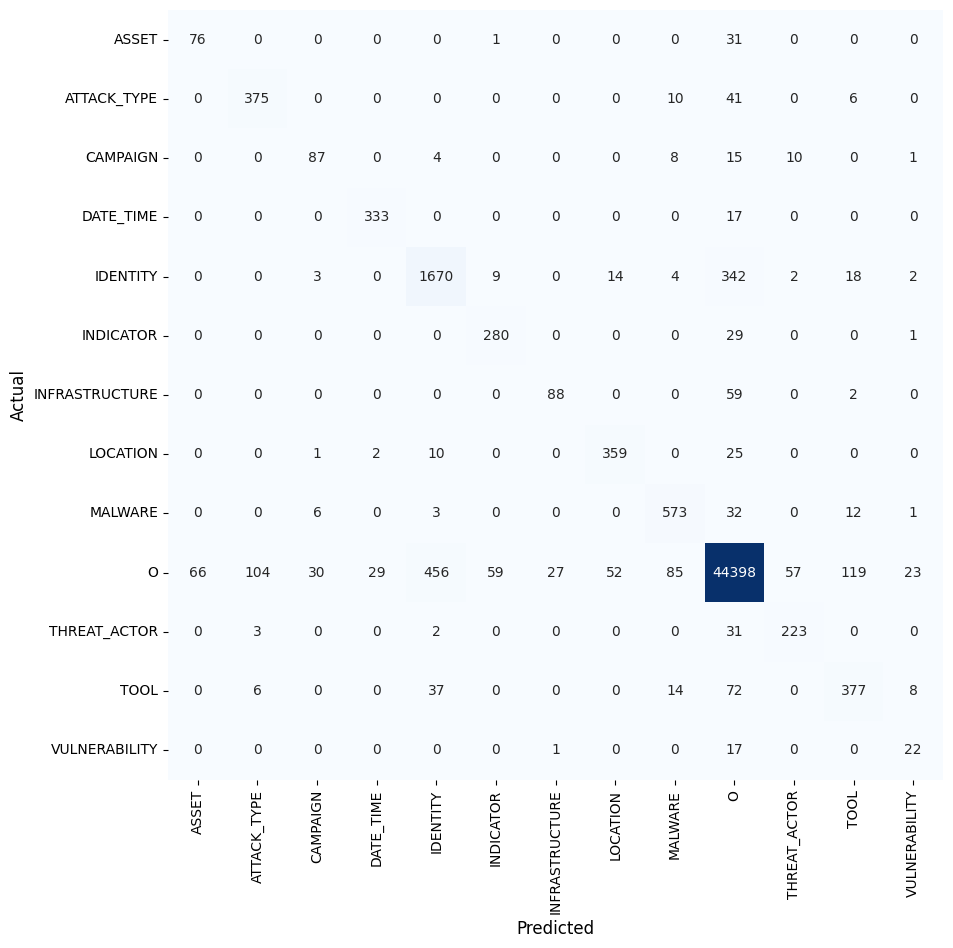

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
cm_array = confusion_matrix(t, p)
cm_labels = np.unique(p)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True,
            cbar=False, fmt='1d', cmap='Blues', ax=ax)
#ax.set_title('Confusion Matrix', loc='left', fontsize=12)
ax.set_xlabel('Predicted',fontsize=12)
ax.set_ylabel('Actual',fontsize=12)
plt.show()

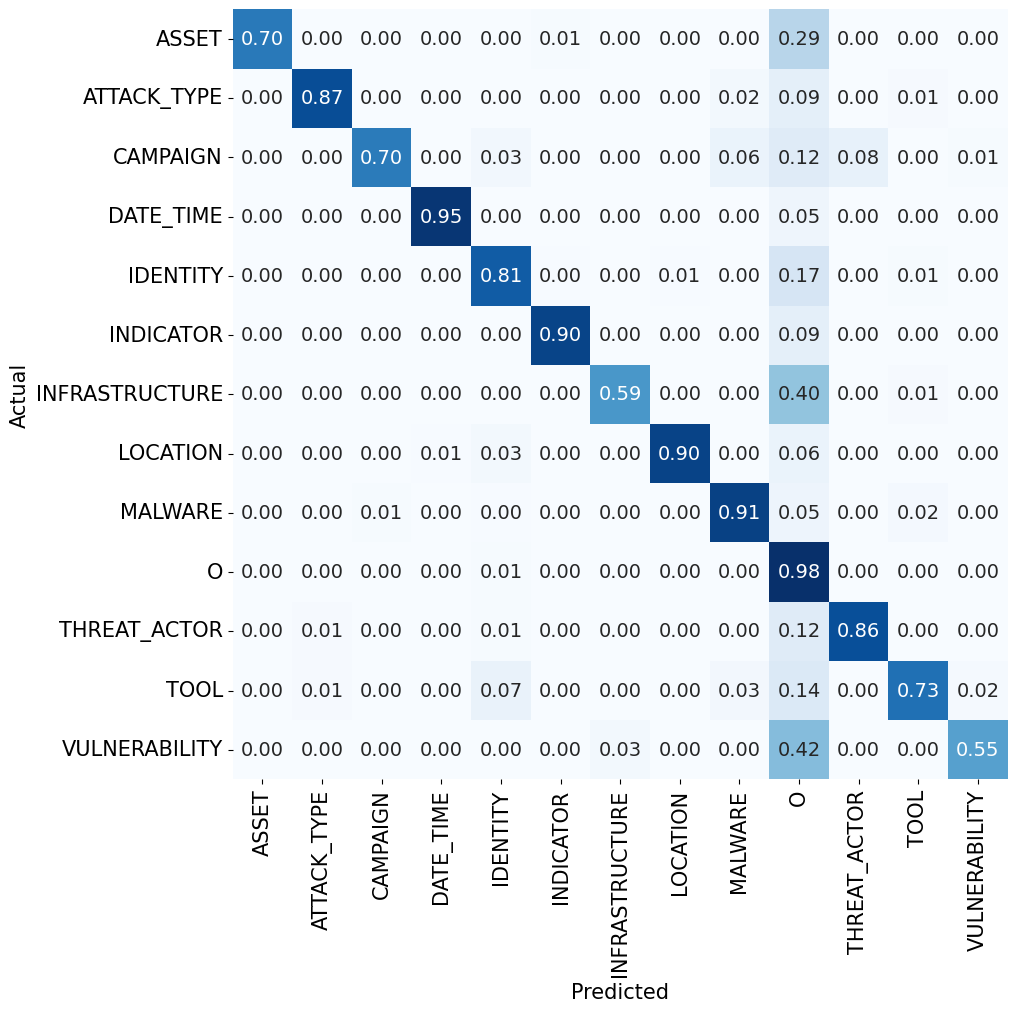

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm_array = confusion_matrix(t, p)

cm_normalized = cm_array.astype('float') / cm_array.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 10))

cm_array_df = pd.DataFrame(cm_normalized, index=np.unique(p), columns=np.unique(p))

annot_font_size = 14 
annot_kws = {'size': annot_font_size}


sns.heatmap(cm_array_df, annot=True, cbar=False, fmt='.2f', cmap='Blues', ax=ax, annot_kws=annot_kws)

ax.set_xlabel('Predicted', fontsize=15)
ax.set_ylabel('Actual', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15) 
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Mini ProjectRisk Msc DS/Main Project/NER/Classification/Best_Model/model.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Mini ProjectRisk Msc DS/Main Project/NER/Classification/Best_Model/model.pth'))
model.eval()

BertLstmCRF(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin